#### Import Libraries

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from sklearn.metrics import average_precision_score
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.losses import categorical_crossentropy
from keras.models import Model
from keras.utils import generic_utils
from tensorflow.keras.layers import Layer

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Define Configuration

Purpose: Define a configuration class to store all settings and parameters needed for training and inference.
Importance: Centralizes configuration settings, making it easier to manage and modify them.

In [2]:
class Config:
    def __init__(self):
        self.verbose = True
        self.network = 'vgg'
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False
        self.anchor_box_scales = [64, 128, 256]
        self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
        self.im_size = 300
        self.img_channel_mean = [103.939, 116.779, 123.68]
        self.img_scaling_factor = 1.0
        self.num_rois = 4
        self.rpn_stride = 16
        self.balanced_classes = False
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5
        self.class_mapping = None
        self.model_path = None

### Data Preprocessing

#### Parse Data from Annotation File

In [3]:
def get_data(input_path):
    found_bg = False
    all_imgs = {}
    classes_count = {}
    class_mapping = {}
    visualise = True
    i = 1
    
    with open(input_path, 'r') as f:
        print('Parsing annotation files')
        for line in f:
            sys.stdout.write('\r' + 'idx=' + str(i))
            i += 1
            line_split = line.strip().split(',')
            (filename, x1, y1, x2, y2, class_name) = line_split

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(filename)
                (rows, cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

            all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})

        all_data = []
        for key in all_imgs:
            all_data.append(all_imgs[key])
        
        if found_bg:
            if class_mapping['bg'] != len(class_mapping) - 1:
                key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping) - 1][0]
                val_to_switch = class_mapping['bg']
                class_mapping['bg'] = len(class_mapping) - 1
                class_mapping[key_to_switch] = val_to_switch
        
        return all_data, classes_count, class_mapping

#### Get New Image Size and Augment the Image

In [4]:
def get_new_img_size(width, height, img_min_side=300):
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side
    return resized_width, resized_height

def augment(img_data, config, augment=True):
    assert 'filepath' in img_data
    assert 'bboxes' in img_data
    assert 'width' in img_data
    assert 'height' in img_data

    img_data_aug = copy.deepcopy(img_data)
    img = cv2.imread(img_data_aug['filepath'])

    if augment:
        rows, cols = img.shape[:2]

        if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
            img = cv2.flip(img, 1)
            for bbox in img_data_aug['bboxes']:
                x1 = bbox['x1']
                x2 = bbox['x2']
                bbox['x2'] = cols - x1
                bbox['x1'] = cols - x2

        if config.use_vertical_flips and np.random.randint(0, 2) == 0:
            img = cv2.flip(img, 0)
            for bbox in img_data_aug['bboxes']:
                y1 = bbox['y1']
                y2 = bbox['y2']
                bbox['y2'] = rows - y1
                bbox['y1'] = rows - y2

        if config.rot_90:
            angle = np.random.choice([0, 90, 180, 270], 1)[0]
            if angle == 270:
                img = np.transpose(img, (1, 0, 2))
                img = cv2.flip(img, 0)
            elif angle == 180:
                img = cv2.flip(img, -1)
            elif angle == 90:
                img = np.transpose(img, (1, 0, 2))
                img = cv2.flip(img, 1)
            elif angle == 0:
                pass

            for bbox in img_data_aug['bboxes']:
                x1 = bbox['x1']
                x2 = bbox['x2']
                y1 = bbox['y1']
                y2 = bbox['y2']
                if angle == 270:
                    bbox['x1'] = y1
                    bbox['x2'] = y2
                    bbox['y1'] = cols - x2
                    bbox['y2'] = cols - x1
                elif angle == 180:
                    bbox['x2'] = cols - x1
                    bbox['x1'] = cols - x2
                    bbox['y2'] = rows - y1
                    bbox['y1'] = rows - y2
                elif angle == 90:
                    bbox['x1'] = rows - y2
                    bbox['x2'] = rows - y1
                    bbox['y1'] = x1
                    bbox['y2'] = x2
                elif angle == 0:
                    pass

    img_data_aug['width'] = img.shape[1]
    img_data_aug['height'] = img.shape[0]
    return img_data_aug, img

#### Generate the Ground Truth Anchors

In [5]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
    while True:
        for img_data in all_img_data:
            try:
                if mode == 'train':
                    img_data_aug, x_img = augment(img_data, C, augment=True)
                else:
                    img_data_aug, x_img = augment(img_data, C, augment=False)

                (width, height) = (img_data_aug['width'], img_data_aug['height'])
                (rows, cols, _) = x_img.shape

                assert cols == width
                assert rows == height

                (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
                debug_img = x_img.copy()

                try:
                    y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
                except:
                    continue

                x_img = x_img[:, :, (2, 1, 0)]
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= C.img_channel_mean[0]
                x_img[:, :, 1] -= C.img_channel_mean[1]
                x_img[:, :, 2] -= C.img_channel_mean[2]
                x_img /= C.img_scaling_factor

                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)

                y_rpn_regr[:, y_rpn_regr.shape[1] // 2:, :, :] *= C.std_scaling

                x_img = np.transpose(x_img, (0, 2, 3, 1))
                y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

                yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

            except Exception as e:
                print(e)
                continue

### Fatser R-CNN Architecture

#### Backbone model

In [6]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length // 16
    return get_output_length(width), get_output_length(height)

def nn_base(input_tensor=None, trainable=False):
    input_shape = (None, None, 3)
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    bn_axis = 3

    # VGG-like blocks
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # ResNet-like blocks
    def res_block(input_tensor, filters, stage, block):
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        
        x = Conv2D(filters, (3, 3), padding='same', name=conv_name_base + '2a')(input_tensor)
        x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters, (3, 3), padding='same', name=conv_name_base + '2b')(x)
        x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
        
        x = Add()([x, input_tensor])
        x = Activation('relu')(x)
        return x

    x = res_block(x, 256, stage=3, block='a')
    x = res_block(x, 256, stage=3, block='b')
    x = res_block(x, 256, stage=3, block='c')
    
    # Downsampling by 16
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='downsample_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='downsample_pool1')(x)

    return x



####  RPN layer

Define the Region Proposal Network (RPN) that generates region proposals from the feature maps.

In [7]:
def rpn_layer(base_layers, num_anchors):
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class, x_regr, base_layers]

#### Calculate RPN for All Anchors of All Images

Calculate the RPN outputs (objectness scores and bounding box regressions) for all anchors.

In [8]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios
    num_anchors = len(anchor_sizes) * len(anchor_ratios)

    (output_width, output_height) = img_length_calc_function(resized_width, resized_height)
    n_anchratios = len(anchor_ratios)

    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

    num_bboxes = len(img_data['bboxes'])

    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(n_anchratios):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]

            for ix in range(output_width):
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2

                if x1_anc < 0 or x2_anc > resized_width:
                    continue

                for jy in range(output_height):
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    if y1_anc < 0 or y2_anc > resized_height:
                        continue

                    bbox_type = 'neg'
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc) / 2.0
                            cya = (y1_anc + y2_anc) / 2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                        if img_data['bboxes'][bbox_num]['class'] != 'bg':
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num, :] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num, :] = [tx, ty, tw, th]

                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start + 4] = best_regr

    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], best_anchor_for_bbox[idx, 2] + n_anchratios * best_anchor_for_bbox[idx, 3]] = 1
            y_rpn_overlap[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], best_anchor_for_bbox[idx, 2] + n_anchratios * best_anchor_for_bbox[idx, 3]] = 1
            start = 4 * (best_anchor_for_bbox[idx, 2] + n_anchratios * best_anchor_for_bbox[idx, 3])
            y_rpn_regr[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], start:start + 4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

    num_pos = len(pos_locs[0])
    num_regions = 256

    if len(pos_locs[0]) > num_regions / 2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions / 2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions / 2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### ROI Pooling Convolutional Layer

Define the ROI pooling layer that extracts fixed-size feature maps from the proposed regions.

In [9]:
class RoiPoolingConv(Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)
        img = x[0]
        rois = x[1]
        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize(img[:, y:y + h, x:x + w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))
        return final_output

    def get_config(self):
        config = {'pool_size': self.pool_size, 'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Calculate IoU (Intersection of Union) 

Calculate the IoU between two bounding boxes a and b

In [10]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Non-Max Suppression

Apply non-max suppression to remove redundant and overlapping bounding boxes.

In [11]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    if len(boxes) == 0:
        return []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int
        area_union = area[i] + area[idxs[:last]] - area_int
        overlap = area_int / (area_union + 1e-6)

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
        if len(pick) >= max_boxes:
            break

    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs


#### Apply Regression

Apply bounding box regression adjustments to the proposed regions.

In [12]:
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w / 2.
        cy = y + h / 2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1 / 2.
        y1 = cy1 - h1 / 2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    try:
        cx = x + w / 2.
        cy = y + h / 2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1 / 2.
        y1 = cy1 - h1 / 2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))
        return x1, y1, w1, h1
    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h


#### Convert RPN to ROI Bboxes

Convert the RPN outputs to actual region proposals (ROIs)

In [13]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300, overlap_thresh=0.9):
    regr_layer = regr_layer / C.std_scaling
    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios

    assert rpn_layer.shape[0] == 1
    (rows, cols) = rpn_layer.shape[1:3]
    curr_layer = 0
    A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:
            anchor_x = (anchor_size * anchor_ratio[0]) / C.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1]) / C.rpn_stride

            regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
            regr = np.transpose(regr, (2, 0, 1))

            X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
            A[0, :, :, curr_layer] = X - anchor_x / 2
            A[1, :, :, curr_layer] = Y - anchor_y / 2
            A[2, :, :, curr_layer] = anchor_x
            A[3, :, :, curr_layer] = anchor_y

            if use_regr:
                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

            A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

            A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
            A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

            A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
            A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
            A[2, :, :, curr_layer] = np.minimum(cols - 1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.minimum(rows - 1, A[3, :, :, curr_layer])

            curr_layer += 1

    all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
    all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]

    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
    all_boxes = np.delete(all_boxes, idxs, 0)
    all_probs = np.delete(all_probs, idxs, 0)

    result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]
    return result


#### Calculate IoU

Calculate IoUs between a set of region proposals and ground truth boxes, and prepare data for training the classifier.

In [14]:
def calc_iou(R, img_data, C, class_mapping):
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))
    for bbox_num, bbox in enumerate(bboxes):
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width)) / C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width)) / C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height)) / C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height)) / C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = []

    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
            continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0
                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4 + label_pos] = [sx * tx, sy * ty, sw * tw, sh * th]
            labels[label_pos:4 + label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    X = np.array(x_roi)
    Y1 = np.array(y_class_num)
    Y2 = np.concatenate([np.array(y_class_regr_label), np.array(y_class_regr_coords)], axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs


#### Define loss functions for all four outputs

In [15]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [16]:
def rpn_loss_regr(num_anchors):
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])
    return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):
    def rpn_loss_cls_fixed_num(y_true, y_pred):
        return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
    return rpn_loss_cls_fixed_num

def class_loss_regr(num_classes):
    def class_loss_regr_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        x = y_true[:, :, 4 * num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4 * num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4 * num_classes])
    return class_loss_regr_fixed_num

def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

#### Classifier layer

In [17]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes=4):
    input_shape = (num_rois, 7, 7, 512)
    pooling_regions = 7
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes - 1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]



---





---



### Start training

In [18]:
base_path = ""


train_path =  '../dataset/annotations/annotation.txt' # Training data (annotation file)

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_hybrid_new_test.hdf5')

record_path = os.path.join(base_path, 'model/record-hybrid-new-test.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(base_path,'')

config_output_filename = os.path.join(base_path, 'model_frcnn_config_test.pickle')

In [19]:
# Create the config
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [22]:
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=2450
Spend 0.11 mins to load the data


In [23]:
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C, config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Training images per class:
{'Glioma': 1140, 'Meningioma': 566, 'Pituitary Tumor': 744, 'bg': 0}
Num classes (including bg) = 4
{'Meningioma': 0, 'Glioma': 1, 'Pituitary Tumor': 2, 'bg': 3}
Config has been written to model_frcnn_config_test.pickle, and can be loaded when testing to ensure correct results


In [24]:
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 2450


In [25]:
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

*next(data_gen_train) to generate a batch of training data*

In [26]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

- Outputs the dimensions of the original and resized images, feature map size, and shapes of the RPN outputs.
- If there are positive anchors, it prints their details and draws the ground truth bounding box along with the positive anchors on the image.
- Shows the annotated image with the ground truth and positive anchors for visual inspection.

Original image: height=512 width=512
Resized image:  height=300 width=300 C.im_size=300
Feature map size: height=18 width=18 C.rpn_stride=16
(1, 300, 300, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 18, 18)
Shape of y_rpn_regr (1, 18, 18, 72)
{'filepath': '../dataset/train/1550.jpg', 'width': 512, 'height': 512, 'bboxes': [{'class': 'Pituitary Tumor', 'x1': 209, 'x2': 278, 'y1': 225, 'y2': 287}]}
Number of positive anchors for this image: 1
(array([6, 9, 9], dtype=int64), array([13,  8,  8], dtype=int64), array([0, 0, 9], dtype=int64))
(array([9, 9, 9, 9], dtype=int64), array([8, 8, 8, 8], dtype=int64), array([0, 1, 2, 3], dtype=int64))
y_rpn_cls for possible pos anchor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 1.          1.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

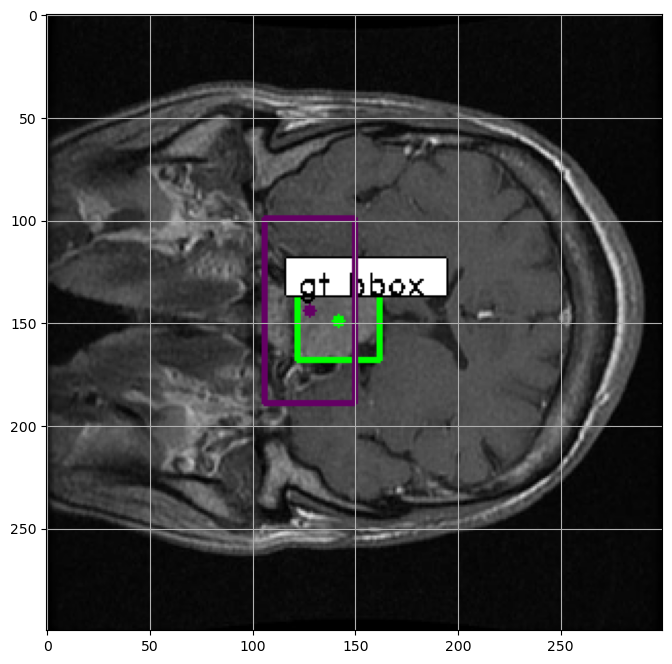

In [27]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    for i in range(debug_num_pos):
        color = (100 + i * (155 / 4), 0, 100 + i * (155 / 4))
        idx = pos_regr[2][i * 4] / 4
        anchor_size = C.anchor_box_scales[int(idx / 3)]
        anchor_ratio = C.anchor_box_ratios[2 - int((idx + 1) % 3)]

        center = (pos_regr[1][i * 4] * C.rpn_stride, pos_regr[0][i * 4] * C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size * anchor_ratio[0], anchor_size * anchor_ratio[1]
        cv2.rectangle(img, (center[0] - int(anc_w / 2), center[1] - int(anc_h / 2)), (center[0] + int(anc_w / 2), center[1] + int(anc_h / 2)), color, 2)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8, 8))
plt.grid()
plt.imshow(img)
plt.show()

### Build the model

In [28]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

shared_layers = nn_base(img_input, trainable=True)

In [ ]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)


if not os.path.isfile(C.model_path):
    print('This is the first time of your training. Initializing weights randomly.')
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

In [30]:
optimizer = Adam(learning_rate=1e-5)
optimizer_classifier = Adam(learning_rate=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [31]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 4000
num_epochs = 380
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [31]:
print(len(record_df))

380


In [32]:
import os

model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [ ]:
start_time = time.time()
for epoch_num in range(num_epochs):
    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:
            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor)) / len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []

                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append(len(pos_samples))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois // 2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois // 2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]
            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), 
                                      ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), 
                                      ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time() - start_time) / 60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss, curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = pd.DataFrame({'mean_overlapping_bboxes': [round(mean_overlapping_bboxes, 3)], 
                                        'class_acc': [round(class_acc, 3)], 
                                        'loss_rpn_cls': [round(loss_rpn_cls, 3)], 
                                        'loss_rpn_regr': [round(loss_rpn_regr, 3)], 
                                        'loss_class_cls': [round(loss_class_cls, 3)], 
                                        'loss_class_regr': [round(loss_class_regr, 3)], 
                                        'curr_loss': [round(curr_loss, 3)], 
                                        'elapsed_time': [round(elapsed_time, 3)], 
                                        'mAP': [0]})
                record_df = pd.concat([record_df, new_row], ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

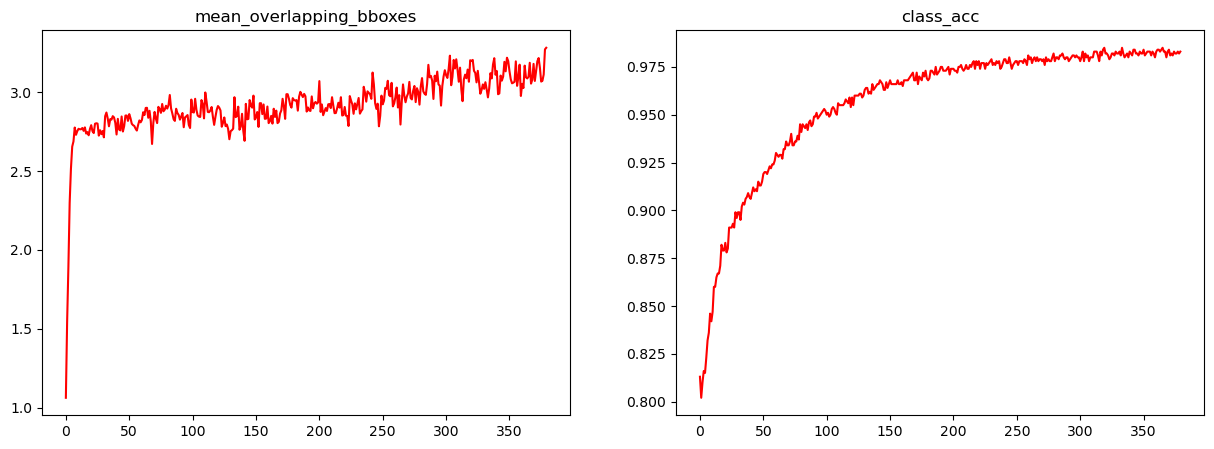

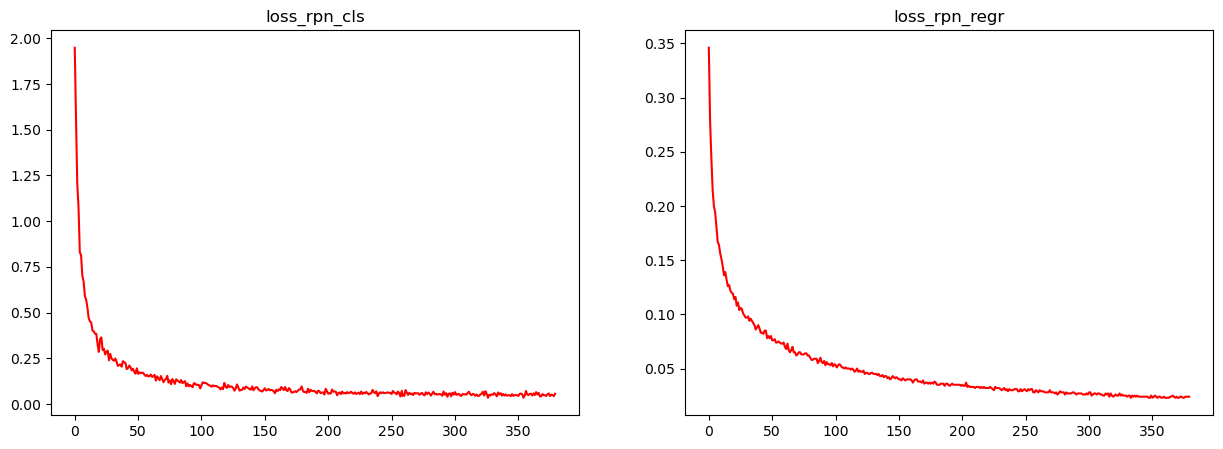

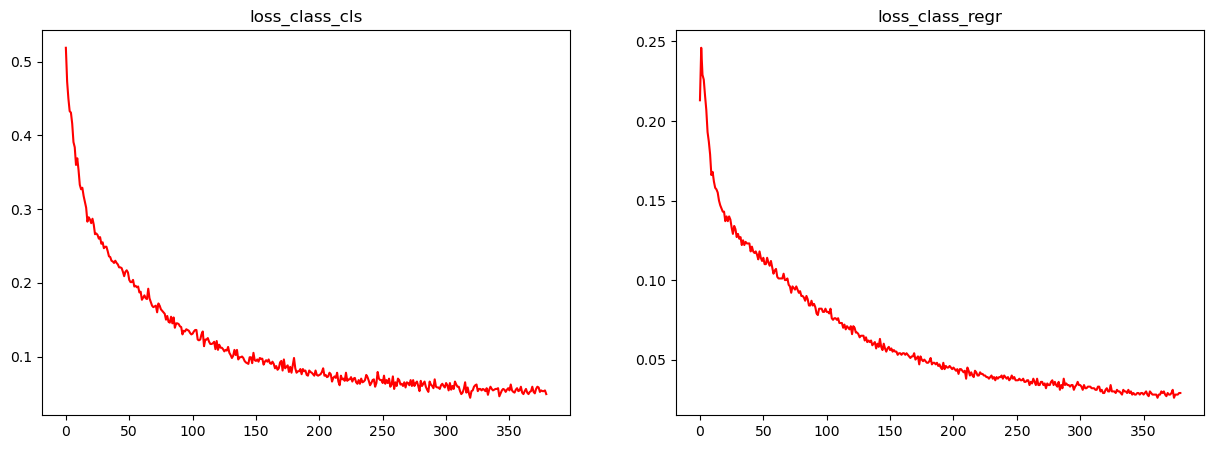

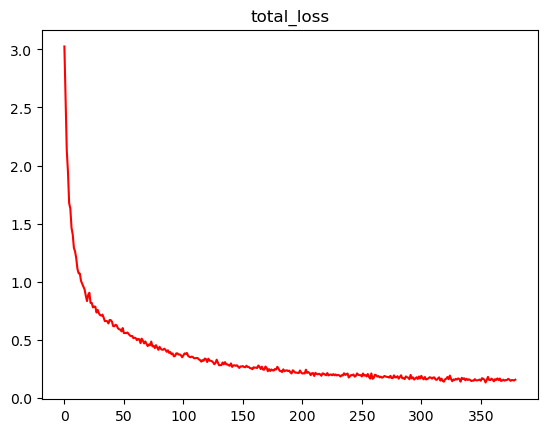

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the pandas Series to numpy arrays
mean_overlapping_bboxes = np.array(record_df['mean_overlapping_bboxes'])
class_acc = np.array(record_df['class_acc'])
loss_rpn_cls = np.array(record_df['loss_rpn_cls'])
loss_rpn_regr = np.array(record_df['loss_rpn_regr'])
loss_class_cls = np.array(record_df['loss_class_cls'])
loss_class_regr = np.array(record_df['loss_class_regr'])
curr_loss = np.array(record_df['curr_loss'])

# Determine the minimum length among the arrays
min_length = min(len(mean_overlapping_bboxes), len(class_acc), len(loss_rpn_cls), len(loss_rpn_regr), len(loss_class_cls), len(loss_class_regr), len(curr_loss))

# Ensure that r_epochs has the same length as the data arrays
r_epochs = np.arange(min_length)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(r_epochs, mean_overlapping_bboxes[:min_length], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1, 2, 2)
plt.plot(r_epochs, class_acc[:min_length], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(r_epochs, loss_rpn_cls[:min_length], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1, 2, 2)
plt.plot(r_epochs, loss_rpn_regr[:min_length], 'r')
plt.title('loss_rpn_regr')

plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(r_epochs, loss_class_cls[:min_length], 'r')
plt.title('loss_class_cls')

plt.subplot(1, 2, 2)
plt.plot(r_epochs, loss_class_regr[:min_length], 'r')
plt.title('loss_class_regr')

plt.show()

plt.plot(r_epochs, curr_loss[:min_length], 'r')
plt.title('total_loss')
plt.show()
